In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.legendre.setup_legendre import SimulationSetupLegendre
from operators.poisson_solver import gmres_solver
from operators.legendre.legendre_operators import xi_legendre, charge_density_legendre, total_mass_legendre, total_momentum_legendre, total_energy_k_legendre

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Enable LaTeX rendering
matplotlib.rcParams['text.usetex'] = True

In [4]:
# Get the 'inferno' colormap
inferno_cmap = plt.get_cmap('inferno')

# Sample the colormap at three different points (e.g., 25%, 50%, 75%)
color1 = inferno_cmap(0.)
color2 = inferno_cmap(0.4)
color3 = inferno_cmap(0.75)

# Distribution function comparison

In [5]:
def my_function(x, a, b):
    return a * x + b

In [6]:
Nv_vec = [32, 64, 128, 256]
x = np.linspace(0, 2*np.pi, 101, endpoint=True)
v = np.linspace(-4, 4, 15000, endpoint=True)

In [7]:
E_truth = np.load("/Users/oissan/PycharmProjects/mixed_methods/data/legendre/two_stream/E_field_512_Nx_101_0_35.npy")
f_truth = np.load("/Users/oissan/PycharmProjects/mixed_methods/data/legendre/two_stream/distribution_t_35_512_Nx_101_0_35.npy")[:-1, :]

Nv= 32
Nv= 64
Nv= 128
Nv= 256


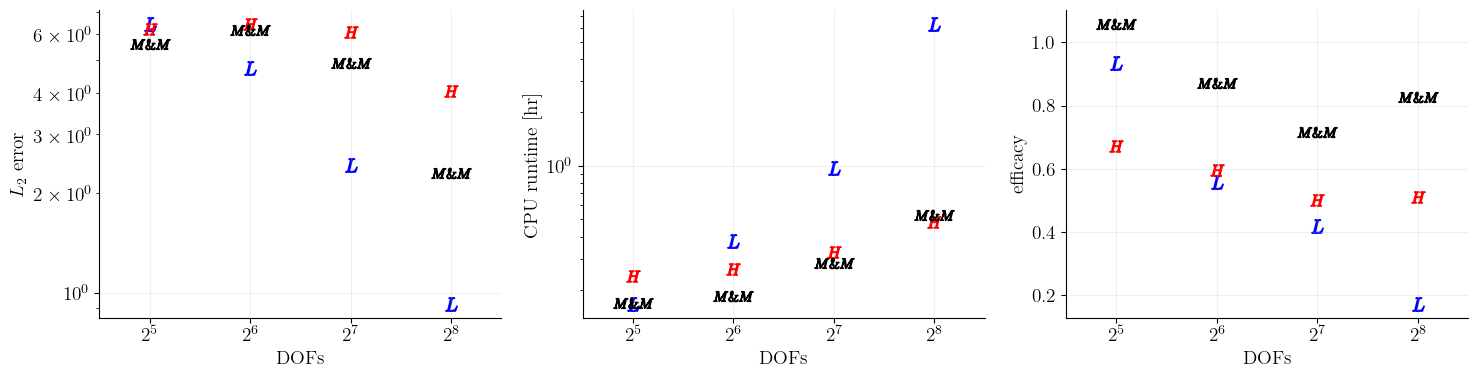

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 4), sharex=True)

for Nv in Nv_vec:
    print("Nv=", Nv)
    f_legendre = np.load("../data/legendre/two_stream/distribution_t_35_" + str(Nv) + "_Nx_101_0_35.npy")[:-1, :]
    f_hermite = np.load("../data/aw_hermite/two_stream/distribution_t_35_" + str(Nv) + "_Nx_101_0_35.npy")[:-1, :]
    f_mm = np.load("../data/mixed_method_1_aw_hermite_legendre/two_stream/distribution_t_35_" + str(Nv//2) + "_NvL_" + str(Nv//2) +"_Nx_101_0_35.npy")[:-1, :]
    # compute errors
    error_legendre = np.linalg.norm(np.abs(f_legendre - f_truth), ord=1)
    error_hermite = np.linalg.norm(np.abs(f_hermite - f_truth), ord=1)
    error_mm = np.linalg.norm(np.abs(f_mm - f_truth), ord=1)
    
    ax[0].scatter(Nv, error_legendre, marker=f"$L$", color="blue", s=90)
    ax[0].scatter(Nv, error_hermite, marker=f"$H$", color="red", s=90)
    ax[0].scatter(Nv, error_mm, marker=f"$M\& M$", color="black", s=800)

    runtime_legendre = np.load("../data/legendre/two_stream/sol_runtime_Nv_" + str(Nv) + "_Nx_101_0_35.npy")/60/60
    runtime_hermite = np.load("../data/aw_hermite/two_stream/sol_runtime_Nv_" + str(Nv) + "_Nx_101_0_35.npy")/60/60
    runtime_mm = np.load("../data/mixed_method_1_aw_hermite_legendre/two_stream/sol_runtime_NvH_" + str(Nv//2) + "_NvL_" + str(Nv//2) +"_Nx_101_0_35.npy")/60/60
    
    ax[1].scatter(Nv, runtime_legendre[0], marker=f"$L$", color="blue", s=90)
    ax[1].scatter(Nv, runtime_hermite[0], marker=f"$H$", color="red", s=90)
    ax[1].scatter(Nv, runtime_mm[0], marker=f"$M\& M$", color="black", s=800)

    ax[2].scatter(Nv, 1/(runtime_legendre[0]*error_legendre), marker=f"$L$", color="blue", s=90)
    ax[2].scatter(Nv, 1/(runtime_hermite[0]*error_hermite), marker=f"$H$", color="red", s=90)
    ax[2].scatter(Nv, 1/(runtime_mm[0]*error_mm), marker=f"$M\& M$", color="black", s=800)
    
ax[0].set_xlim(2**4.5, 2**8.5)
ax[0].set_yscale("log")
ax[0].set_xticks(Nv_vec)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].grid(alpha=0.2)
ax[0].set_xlabel("DOFs")
ax[0].set_ylabel("$L_{2}$ error")


ax[1].set_xscale('log', base=2)
ax[1].set_xticks(Nv_vec)
ax[1].set_yscale("log")
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].grid(alpha=0.2)
ax[1].set_xlabel("DOFs")
ax[1].set_ylabel("CPU runtime [hr]")


#ax[2].set_yscale("log")
ax[2].set_xticks(Nv_vec)
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].grid(alpha=0.2)
ax[2].set_xlabel("DOFs")
ax[2].set_ylabel("efficacy")
plt.tight_layout()
plt.savefig("../figures/comparison/error_runtime_efficacy_distribution.png", dpi=600)

In [10]:
error_legendre = np.zeros(len(Nv_vec))
error_hermite = np.zeros(len(Nv_vec))
error_mm = np.zeros(len(Nv_vec))

In [11]:
for ii, Nv in enumerate(Nv_vec):
    f_legendre = np.load("../data/legendre/two_stream/distribution_t_35_" + str(Nv) + "_Nx_101_0_35.npy")[:-1, :]
    f_hermite = np.load("../data/aw_hermite/two_stream/distribution_t_35_" + str(Nv) + "_Nx_101_0_35.npy")[:-1, :]
    f_mm = np.load("../data/mixed_method_1_aw_hermite_legendre/two_stream/distribution_t_35_" + str(Nv//2) + "_NvL_" + str(Nv//2) +"_Nx_101_0_35.npy")[:-1, :]
    # compute errors
    error_legendre[ii] = np.linalg.norm(np.abs(f_legendre - f_truth), ord=1)
    error_hermite[ii] = np.linalg.norm(np.abs(f_hermite - f_truth), ord=1)
    error_mm[ii] = np.linalg.norm(np.abs(f_mm - f_truth), ord=1)

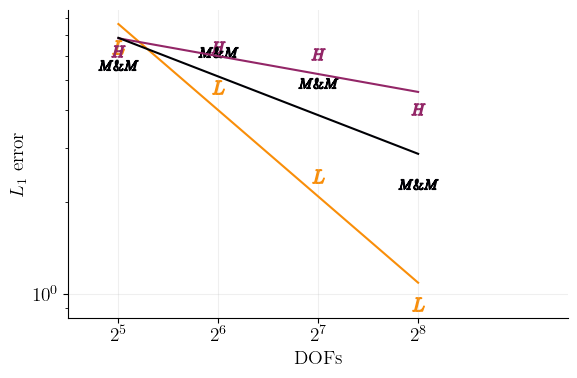

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(Nv_vec, error_legendre, marker=f"$L$", color=color3, s=90)
popt, pcov = scipy.optimize.curve_fit(my_function, np.log10(Nv_vec), np.log10(error_legendre), p0=[-1, 1])
ax.plot(Nv_vec, 10**(my_function(np.log10(Nv_vec), popt[0], popt[1])), color=color3, label=r"$\lambda_{L} = $" + str(round(popt[0], 1)))

ax.scatter(Nv_vec, error_hermite, marker=f"$H$", color=color2, s=90)
popt, pcov = scipy.optimize.curve_fit(my_function, np.log10(Nv_vec), np.log10(error_hermite), p0=[-1, 1])
ax.plot(Nv_vec, 10**(my_function(np.log10(Nv_vec), popt[0], popt[1])), color=color2 , label=r"$\lambda_{H} = $" + str(round(popt[0], 1)))

ax.scatter(Nv_vec, error_mm, marker=f"$M\& M$", color=color1, s=800)
popt, pcov = scipy.optimize.curve_fit(my_function, np.log10(Nv_vec), np.log10(error_mm), p0=[-1, 1])
ax.plot(Nv_vec, 10**(my_function(np.log10(Nv_vec), popt[0], popt[1])), color=color1,  label=r"$\lambda_{M \& M} = $" + str(round(popt[0], 1)))

ax.set_xlim(2**4.5, 2**9.5)
ax.set_yscale("log")
#ax.set_yticks([10, 1])
ax.set_xscale('log', base=2)
ax.set_xticks(Nv_vec)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(alpha=0.2)
ax.set_xlabel("DOFs")
ax.set_ylabel("$L_{1}$ error")
plt.tight_layout()
plt.savefig("../figures/comparison/error_two_stream.png", dpi=600)

In [13]:
error_legendre = np.zeros(len(Nv_vec))
error_hermite = np.zeros(len(Nv_vec))
error_mm = np.zeros(len(Nv_vec))

In [14]:
for ii, Nv in enumerate(Nv_vec):
    E_legendre = np.load("../data/legendre/two_stream/E_field_" + str(Nv) + "_Nx_101_0_35.npy")
    E_hermite = np.load("../data/aw_hermite/two_stream/E_field_" + str(Nv) + "_Nx_101_0_35.npy")
    E_mm = np.load("../data/mixed_method_1_aw_hermite_legendre/two_stream/E_field_"  + str(Nv//2) + "_NvL_" + str(Nv//2) +"_Nx_101_0_35.npy")
    # compute errors
    error_legendre[ii] = np.linalg.norm(np.abs(E_legendre - E_truth[:, :]), ord=2)
    error_hermite[ii] = np.linalg.norm(np.abs(E_hermite - E_truth[:, :]), ord=2)
    error_mm[ii] = np.linalg.norm(np.abs(E_mm - E_truth[:, :]), ord=2)

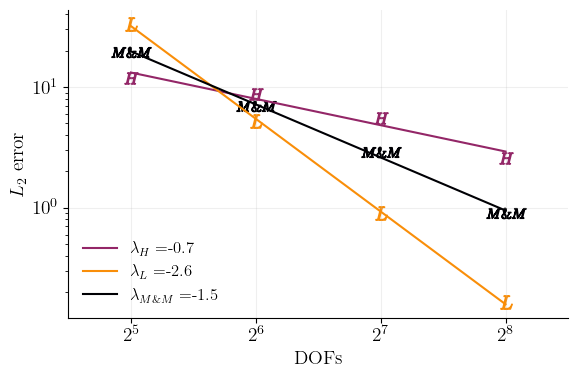

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))


ax.scatter(Nv_vec, error_hermite, marker=f"$H$", color=color2, s=90)
popt, pcov = scipy.optimize.curve_fit(my_function, np.log10(Nv_vec), np.log10(error_hermite), p0=[-1, 1])
ax.plot(Nv_vec, 10**(my_function(np.log10(Nv_vec), popt[0], popt[1])), color=color2 , label=r"$\lambda_{H} = $" + str(round(popt[0], 1)))

ax.scatter(Nv_vec, error_legendre, marker=f"$L$", color=color3, s=90)
popt, pcov = scipy.optimize.curve_fit(my_function, np.log10(Nv_vec), np.log10(error_legendre), p0=[-1, 1])
ax.plot(Nv_vec, 10**(my_function(np.log10(Nv_vec), popt[0], popt[1])), color=color3, label=r"$\lambda_{L} = $" + str(round(popt[0], 1)))

ax.scatter(Nv_vec, error_mm, marker=f"$M\& M$", color=color1, s=800)
popt, pcov = scipy.optimize.curve_fit(my_function, np.log10(Nv_vec), np.log10(error_mm), p0=[-1, 1])
ax.plot(Nv_vec, 10**(my_function(np.log10(Nv_vec), popt[0], popt[1])), color=color1,  label=r"$\lambda_{M \& M} = $" + str(round(popt[0], 1)))

ax.set_xlim(2**4.5, 2**8.5)
ax.set_yscale("log", base=10)
ax.set_xscale('log', base=2)
ax.set_xticks(Nv_vec)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(alpha=0.2)
ax.set_xlabel("DOFs")
ax.set_ylabel("$L_{2}$ error")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='lower left')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figures/comparison/error_two_stream.png", dpi=600)

In [17]:
runtime_legendre = np.zeros(len(Nv_vec))
runtime_hermite = np.zeros(len(Nv_vec))
runtime_mm = np.zeros(len(Nv_vec))

for ii, Nv in enumerate(Nv_vec):
    runtime_legendre[ii] = np.load("../data/legendre/two_stream/sol_runtime_Nv_" + str(Nv) + "_Nx_101_0_35.npy")[0]/60/60
    runtime_hermite[ii] = np.load("../data/aw_hermite/two_stream/sol_runtime_Nv_" + str(Nv) + "_Nx_101_0_35.npy")[0]/60/60
    runtime_mm[ii] = np.load("../data/mixed_method_1_aw_hermite_legendre/two_stream/sol_runtime_NvH_" + str(Nv//2) + "_NvL_" + str(Nv//2) +"_Nx_101_0_35.npy")[0]/60/60

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_38355/857430378.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper left')


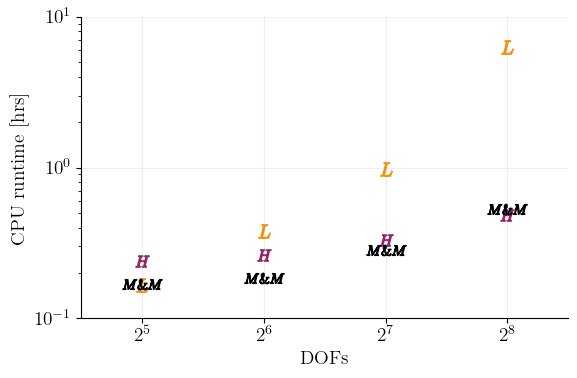

In [37]:
fig, ax = plt.subplots(figsize=(6, 4))
 
ax.scatter(Nv_vec, runtime_legendre, marker=f"$L$", color=color3, s=90)
ax.scatter(Nv_vec, runtime_hermite, marker=f"$H$", color=color2, s=90)
ax.scatter(Nv_vec, runtime_mm, marker=f"$M\& M$", color=color1, s=800)
# ax.plot(Nv_vec, 0.0001*(np.array(Nv_vec)**2 - Nv_vec), color=color3, label="$\propto N_{v}^2 - N_{v}$", alpha=0.5)
# ax.plot(Nv_vec, 0.004*(np.array(Nv_vec) - 1), color=color2, label="$\propto N_{v} - 1$", alpha=0.5)
# ax.plot(Nv_vec, 0.0001*(np.array(Nv_vec)**2 - Nv_vec), color=color3, label="$\propto N_{v}^2 - N_{v}$", alpha=0.5)
ax.set_xlim(2**4.5, 2**8.5)
ax.set_yscale("log")
ax.set_xscale('log', base=2)
ax.set_yticks([1e-1, 1, 10])
ax.set_xticks(Nv_vec)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(alpha=0.2)
ax.set_xlabel("DOFs")
ax.set_ylabel("CPU runtime [hrs]")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper left')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figures/comparison/runtime_two_stream.png", dpi=600)

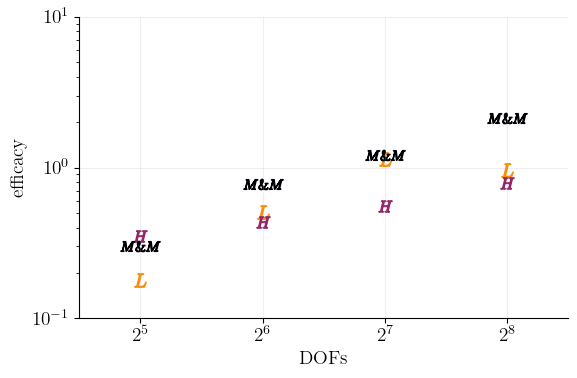

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))


ax.scatter(Nv_vec, 1/(runtime_legendre*error_legendre), marker=f"$L$", color=color3, s=90)
ax.scatter(Nv_vec, 1/(runtime_hermite*error_hermite), marker=f"$H$", color=color2, s=90)
ax.scatter(Nv_vec, 1/(runtime_mm*error_mm), marker=f"$M\& M$", color=color1, s=800)
ax.set_xlim(2**4.5, 2**8.5)
ax.set_yscale("log")
ax.set_yticks([0.1, 1, 10])
ax.set_xscale('log', base=2)
ax.set_xticks(Nv_vec)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(alpha=0.2)
ax.set_xlabel("DOFs")
ax.set_ylabel("efficacy")
plt.tight_layout()
plt.savefig("../figures/comparison/efficacy_two_stream.png", dpi=600)

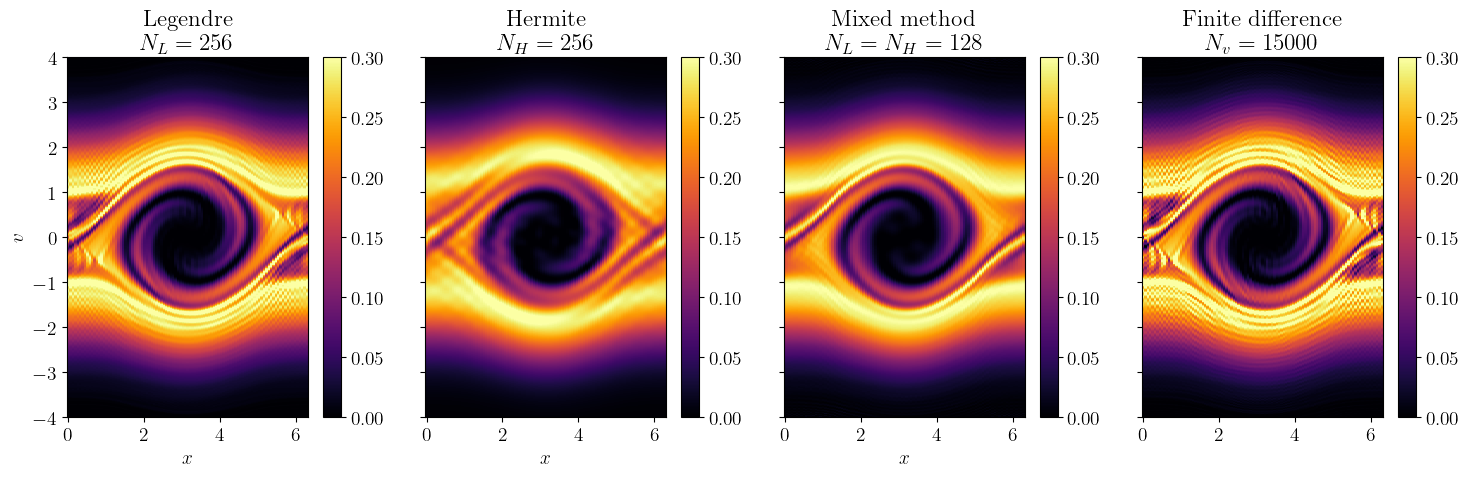

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(15, 5), sharey=True)
pos = ax[0].pcolormesh(x, v, f_legendre.T, cmap="inferno", vmin=0, vmax=0.3)
cbar = fig.colorbar(pos)
pos = ax[1].pcolormesh(x, v, f_hermite.T, cmap="inferno", vmin=0, vmax=0.3)
cbar = fig.colorbar(pos)
pos = ax[2].pcolormesh(x, v, f_mm.T, cmap="inferno", vmin=0, vmax=0.3)
cbar = fig.colorbar(pos)
pos = ax[3].pcolormesh(x, v, f_truth.T, cmap="inferno", vmin=0, vmax=0.3)
cbar = fig.colorbar(pos)
ax[3].set_title("Finite difference \n $N_{v} = 15000$")
ax[2].set_title("Mixed method \n $N_{L} = N_{H} = 128$")
ax[1].set_title("Hermite \n $N_{H} = 256$")
ax[0].set_title("Legendre \n $N_{L} = 256$")
ax[0].set_ylabel("$v$")
ax[0].set_xlabel("$x$")
ax[1].set_xlabel("$x$")
ax[2].set_xlabel("$x$")
plt.tight_layout()
plt.savefig("../figures/comparison/two_stream_distribution.png", dpi=600)